In [1]:
#hide
import sys
import numpy as np
import pandas as pd
import numpy.linalg as la
from matplotlib import animation, pyplot as plt
import proplot as plot
import seaborn as sns
from tqdm import trange

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import (
    plotting as myplt, 
    animation as myanim,
    matrix_lattice as ml
)
from utils_2021_02_15 import (
    k0, FODO, EnvelopeSolver,
    get_perveance, get_sc_factor, DistGenerator,
    rand_rows, vec_to_mat
)

In [2]:
%load_ext cython
import Cython

In [3]:
from scipy.constants import epsilon_0, elementary_charge, speed_of_light, pi
proton_mass = 0.938272029 # [GeV/c^2]
classical_proton_radius = 1.53469e-18 # [m]

In [4]:
#hide
plt.rcParams['animation.html'] = 'jshtml'
plot.rc['figure.facecolor'] = 'white'
plot.rc['savefig.dpi'] = 'figure'

# Particle-in-cell simulation
> An introduction to electrostatic PIC solvers

- toc: true 
- badges: false
- comments: true
- categories: [physics, accelerators, simulation]
- image: images/chart-preview.png

In my research I utilize [PyORBIT](link), one of many particle-in-cell (PIC) simulation codes for particle accelerators. These codes track a beam of particles though the time-varying electromagnetic fields provided by an accelerator; we call this *external focusing*. In addition to external focusing, there are also *internal* forces to consider caused by the electromagnetic interactions between the beam particles. These are known as *space charge* forces, which refers to the charge density of the beam in free space. This post examines the use of computer simulation to understand space charge effects by building a simple simulation engine in Python. Links to relevant books, lectures, and programs are included at the end; I am basically restating parts of these works. I just always find that I understand things better after writing them down.

## Theoretical model 

We'll use *bunch* to refer to a group of particles in three-dimensional (3D) space, and we'll use a local cartesian coordinate system whose origin moves with the center of the bunch as shown below:

<img src='images_2021-02-15/coordinate_system.png' width=500>

The $s$ coordinate specifies the position of the bunch in the accelerator, and the path can be curved. Now for a few assumptions and approximations. First, the center of the bunch is moving at a constant velocity $\beta c$, where $c$ is the speed of light, so the time variable can be replaced by the position $s = \beta c t$. The slope $x' = dx/ds$ can be used instead of the velocity, and we measure it in milliradians based on the small angle approximation. Second, we'll assume the transverse ($x$-$y$) size of the bunch is much smaller than its length, so that for a given transverse slice it is as if the bunch had a uniform density and infinite length in the longitudinal direction. Our focus will be on the transverse dynamics of this slice, as shown below, so each "particle" we track will really be an infinite line of charge.

<img src='images_2021-02-15/coasting_beam.png' width=500>
<figcaption>Credit: G. Franchetti</figcaption>

Another approximation is to neglect any magnetic fields generated by the beam, again valid if the transverse momenta are very small compared to the bunch kinetic energy. All this being said, the equations of motion without any external foces, i.e., in free space, can be written as 

$$ \mathbf{x}'' = \frac{q}{mv_s\gamma^3} \mathbf{E}, \tag{1}$$

where $\mathbf{x} = [x, y]^T$ is the coordinate vector, $\mathbf{E} = [E_x, E_y]^T$ is the self-generated electric field, and $v_s$ is the velocity in the $s$ direction. 

Let's first address the factor $\gamma^{-3}$ in the equation of motion. This means that the space charge force goes to zero as the velocity approaches the speed of light. Ths is because the moving charges generate an attractive magnetic force which grows with velocity, completely cancelling the electric repulsion in the limit $v \rightarrow c$. One may ask: what about the rest frame, in which there is no magnetic field? But special relativity says that electrogmagnetic fields change with reference frame. Using the transformations defined [here](https://en.wikipedia.org/wiki/Classical_electromagnetism_and_special_relativity), you can quickly prove that 

$$\mathbf{E}_{lab} = \frac{\mathbf{E}_{rest}}{\gamma}. \tag{2}$$

This inverse relationship between velocity and the space charge force has real-life consequences. It tells us that space charge is important if 1) the beam is very intense, meaning there are many particles in a small area, or 2) the beam is very energetic, meaning it is moving extremely fast. For example, space charge can usually be ignored in electron beams, which move near the speed of light for very modest energies due to their tiny mass, but is significant in high-intensity, low-energy hadron accelerators such as [FRIB](https://frib.msu.edu), [SNS](https://neutrons.ornl.gov/sns), and [ESS](https://europeanspallationsource.se).

We should now address the difficulty in determining the evolution of this system: the force on a particle in an $n$-particle bunch depends on the positions of the other $n - 1$ particles in the beam. The approach of statistical mechanics to this problem is to introduce a *distribution function* $f(\mathbf{x}, \mathbf{x}', t)$ which gives the number of particles in an infinitesimal volume of phase space. The Vlasov-Poisson system of equations determines the evolution of $f$ (as long as we ignore collisions between particles and any magnetic fields):

$$\frac{\partial{f}}{\partial{s}} + \mathbf{x}'\cdot \frac{\partial{f}}{\partial{\mathbf{x}}} + \mathbf{x}'' \cdot \frac{\partial{f}}{\partial{\mathbf{x}'}}. \tag{3}$$

We know $\mathbf{x''}$ from Eq. (1). The electric field is obtained from the Poisson's equation:

$$ \nabla \cdot \mathbf{E} = -\nabla^2 \phi = \frac{\rho}{\varepsilon_0}. \tag{4}$$

Finally, the transverse charge density $\rho$ is determined by

$$\rho = q \int{f dx'dy'}. \tag{5}$$

Although these equations are easy to write down, they are generally impossible to solve analytically. We need to turn to a computer for help.

## Computational method

We could try to solve the Vlasov equation directly, but this is difficult, especially in 2D or 3D, . On the other end of the spectrum, we could abandon the notion of a fluid in phase space and just track each particle individually, computing the forces using direct sums. But this is infeasible with current hardware; the time complexity would by $O(n^2)$, where $n$ is the number of particles, and $n$ may be on the order of $10^{14}$.

In comes the particle-in-cell (PIC) method. The idea is to track a group of *macroparticles*, each of which represents a large number of real particles, according to Eq. (1). The fields, however, are solved from Eq. (4). The key step is transforming back and forth between a discrete and continuous representation of the bunch. The simulation loop for the PIC method is shown below.

<img src='images_2021-02-15/picloop.png' width=500>

In the next sections I will discuss each of these steps and implement them in Python code. Let's first create a `Bunch` class, which is a simple container for the bunch coordinates. (*Note: there are some constants and helper functions I've imported that I don't define. The whole package is posted on [GitHub](https://github.com/austin-hoover/pic).*)

In [5]:
import numpy as np

class Bunch:
    """Container for distribution of particles in transverse phase space.

    The particles in this 2D model are uniform density line charges of infinite
    length. The default attributes describe a typical bunch in the Spallation
    Neutron Source (SNS) proton accumulator ring.

    Attributes
    ----------
    nparts : float
        Number of macroparticles in the bunch.
    mass : float
        Mass per particle [GeV/c^2].
    charge : float
        Charge per particle [C].
    kin_energy : float
        Kinetic energy per particle [GeV].
    line_density : float
        Longitudinal particle density [1 / m]. Default 1.5e14 / 250.
    line_charge_density : float
        Longitudinal charge density [C / m].
    length : float
        Length of the bunch [m]. Default: 250.
    macrosize : float
        Number of physical particles represented by each macroparticle.
    macrocharge : float
        Charge represented by each macroparticle [C].
    perveance : float
        The dimensionless space charge perveance.
    sc_factor : float
        Factor for space charge kicks such that that x'' = factor * Ex
    X : ndarray, shape (nparts, 4)
        Array of particle coordinates. Columns are [x, x', y, y']. Units are
        meters and radians.
    positions : ndarray, shape (nparts, 2):
        Just the x and y positions (for convenience).
    """
    def __init__(self, intensity=1e14, length=250., mass=0.938, kin_energy=1., 
                 charge=elementary_charge):
        self.nparts = 0
        self.intensity, self.length = intensity, length
        self.mass, self.kin_energy, self.charge = mass, kin_energy, charge
        self.gamma = 1 + (self.kin_energy / self.mass)
        self.beta = np.sqrt(1 - (1 / self.gamma)**2)
        self.line_density = intensity / length
        self.line_charge_density = charge * self.line_density
        self.perveance = get_perveance(self.line_density, self.beta, self.gamma)
        self.sc_factor = get_sc_factor(charge, mass, self.beta, self.gamma)
        self.compute_macrosize()
        self.X, self.positions = None, None
        
    def compute_macrosize(self):
        """Update the macrosize and macrocharge."""
        if self.nparts > 0:
            self.macrosize = self.intensity // self.nparts
        else:
            self.macrosize = 0
        self.macrocharge = self.charge * self.macrosize
                                
    def fill(self, X):
        """Fill with particles."""
        self.X = X if self.X is None else np.vstack([self.X, X])
        self.positions = self.X[:, [0, 2]]
        self.nparts = self.X.shape[0]
        self.compute_macrosize()

    def compute_extremum(self):
        """Get extreme x and y coorinates."""
        self.xmin, self.ymin = np.min(self.positions, axis=0)
        self.xmax, self.ymax = np.max(self.positions, axis=0)
        self.xlim, self.ylim = (self.xmin, self.xmax), (self.ymin, self.ymax)

### Weighting 

Starting from a group of macroparticles, we need to produce a charge density $\rho_{i,j}$ on the grid. The most simple approach is the *nearest grid point (NGP)* method, which, as the name suggests, assigns the full particle charge to the closest grid point. This is commonly called *zero-order weighting*; although it is very fast and easy to implement, it is not commonly used since it can lead to significant noise. A better method called *cloud-in-cell (CIC)* treats each particle as a rectangular, uniform density cloud of charge with dimensions equal to the grid spacing. A fractional part of the charge is assigned based on the fraction of the cloud overlapping with a given cell. This can be thought of as *first-order weighting*. To get a sense of what these methods are doing (in 1D), we can slide a particle across a cell and plot the resulting density of the cell at each position, thus giving an effective particle shape.

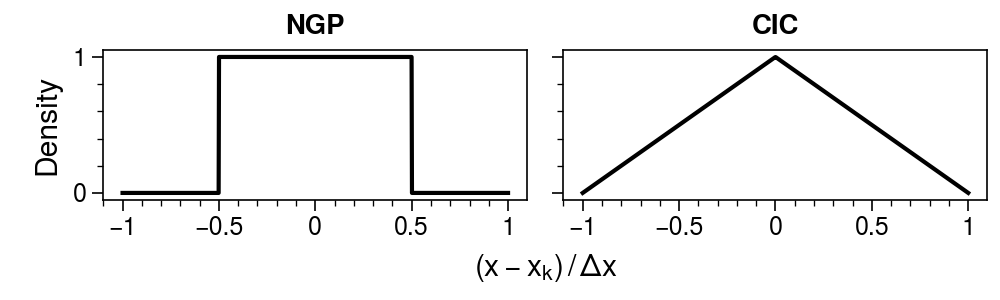

In [6]:
#hide_input
def shape_func(u, v, cell_width, method='ngp'):
    S, diff = 0, np.abs(u - v)
    if method == 'ngp':
        S = 1 if diff < (0.5 * cell_width) else 0
    elif method == 'cic':
        S = 1 - diff/cell_width if diff < cell_width else 0
    return S / cell_width

fig, axes = plot.subplots(ncols=2, figsize=(5, 1.5))
xvals = np.linspace(-1, 1, 1000)
for ax, method in zip(axes, ['ngp', 'cic']):
    densities = [shape_func(x, 0, 1, method) for x in xvals]
    ax.plot(xvals, densities, 'k')
axes.format(
    xlabel='($x - x_k) \,/\, \Delta x$', ylabel='Density', grid=False, 
    xlabel_kw={'size':'large'}, ylabel_kw={'size':'large'}, 
    toplabels=['NGP', 'CIC']
)

We see that the NGP method leads to a discontinuous boundary, while the CIC method leads to a continous boundary (but discontinous derivative). There are also higher order methods which lead to a smooth boundary, but I don't cover those here. 

We also need to perform the reverse operation: given the electric field at each grid point, interpolate the value at each particle position. The same method applies here. NGP just uses the electric field at the nearest grid point, while CIC weights the four nearest grid points. The following `Grid` class implements the CIC method. Notice that I utilized [Cython](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html) in the for-loop in the `distribute` method. I couldn't figure out a way to perform the operation with this loop, and in pure Python it took about 90% of the runtime for a single simulation step. Using Cython gave at least a 5X speed up.

In [7]:
%%cython
import numpy as np
from scipy.interpolate import RegularGridInterpolator

class Grid:
    """Class for 2D grid.

    Attributes
    ----------
    xmin, ymin, xmax, ymax : float
        Minimum and maximum coordinates.
    Nx, Ny : int
        Number of grid points.
    dx, dy : int
        Spacing between grid points.
    x, y : ndarray, shape (Nx,) or (Ny,)
        Positions of each grid point.
    cell_area : float
        Area of each cell.
    """
    def __init__(self, xlim=(-1, 1), ylim=(-1, 1), size=(64, 64)):
        self.xlim, self.ylim = xlim, ylim
        (self.xmin, self.xmax), (self.ymin, self.ymax) = xlim, ylim
        self.size = size
        self.Nx, self.Ny = size
        self.dx = (self.xmax - self.xmin) / (self.Nx - 1)
        self.dy = (self.ymax - self.ymin) / (self.Ny - 1)
        self.cell_area = self.dx * self.dy
        self.x = np.linspace(self.xmin, self.xmax, self.Nx)
        self.y = np.linspace(self.ymin, self.ymax, self.Ny)
        
    def set_lims(self, xlim, ylim):
        """Set the min and max grid coordinates."""
        self.__init__(xlim, ylim, self.size)
        
    def zeros(self):
        """Create array of zeros with same size as the grid."""
        return np.zeros((self.size))

    def distribute(self, positions):
        """Distribute points on the grid using the cloud-in-cell (CIC) method.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
            
        Returns
        -------
        rho : ndarray, shape (Nx, Ny)
            Density at each grid point.
        """
        # Compute area overlapping with 4 nearest neighbors
        ivals = np.floor((positions[:, 0] - self.xmin) / self.dx).astype(int)
        jvals = np.floor((positions[:, 1] - self.ymin) / self.dy).astype(int)
        ivals[ivals > self.Nx - 2] = self.Nx - 2
        jvals[jvals > self.Ny - 2] = self.Ny - 2
        x_i, x_ip1 = self.x[ivals], self.x[ivals + 1]
        y_j, y_jp1 = self.y[jvals], self.y[jvals + 1]
        _A1 = (positions[:, 0] - x_i) * (positions[:, 1] - y_j)
        _A2 = (x_ip1 - positions[:, 0]) * (positions[:, 1] - y_j)
        _A3 = (positions[:, 0] - x_i) * (y_jp1 - positions[:, 1])
        _A4 = (x_ip1 - positions[:, 0]) * (y_jp1 - positions[:, 1])
        # Distribute areas for each point
        rho = self.zeros()
        cdef double[:, :] rho_view = rho 
        cdef int i, j
        for i, j, A1, A2, A3, A4 in zip(ivals, jvals, _A1, _A2, _A3, _A4):
            rho_view[i, j] += A4
            rho_view[i + 1, j] += A3
            rho_view[i, j + 1] += A2
            rho_view[i + 1, j + 1] += A1      
        return rho / self.cell_area

    def interpolate(self, grid_vals, positions):
        """Interpolate values from the grid using the CIC method.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
        grid_vals : ndarray, shape (n, 2)
            Scalar value at each coordinate point.
            
        Returns
        -------
        int_vals : ndarray, shape (nparts,)
            Interpolated value at each position.
        """
        int_func = RegularGridInterpolator((self.x, self.y), grid_vals)
        return int_func(positions)

    def gradient(self, grid_vals):
        """Compute gradient using 2nd order centered differencing.
        
        Parameters
        ----------
        grid_vals : ndarray, shape (Nx, Ny)
            Scalar values at each grid point.
        neg : Bool
            If True, return the negative of the gradient.
            
        Returns
        -------
        gradx, grady : ndarray, shape (Nx, Ny)
            The x and y gradient at each grid point.
        """
        return np.gradient(grid_vals, self.dx, self.dy)

It should be mentioned that the field interpolation method should be the same as the charge deposition method; if this is not true, it is possible for a particle to exert a force on itself! The `RegularGridInterpolator` class implements this for us, but I couldn't find anything similar to deposit the charges. Let's test the method on a gaussian distribution of 100,000 macroparticles in the $x$-$y$ plane, truncated at three standard devations. We'll choose the number of grid points to be $N_x = N_y = 64$. I call a `DistGenerator` class that I don't show here.

In [8]:
dg = DistGenerator()
bunch = Bunch()
bunch.fill(dg.generate(kind='gauss', nparts=int(1e5), cut=3.))
bunch.compute_extremum()

grid = Grid(bunch.xlim, bunch.ylim, size=(64, 64))
rho = bunch.line_density * grid.distribute(bunch.positions) 

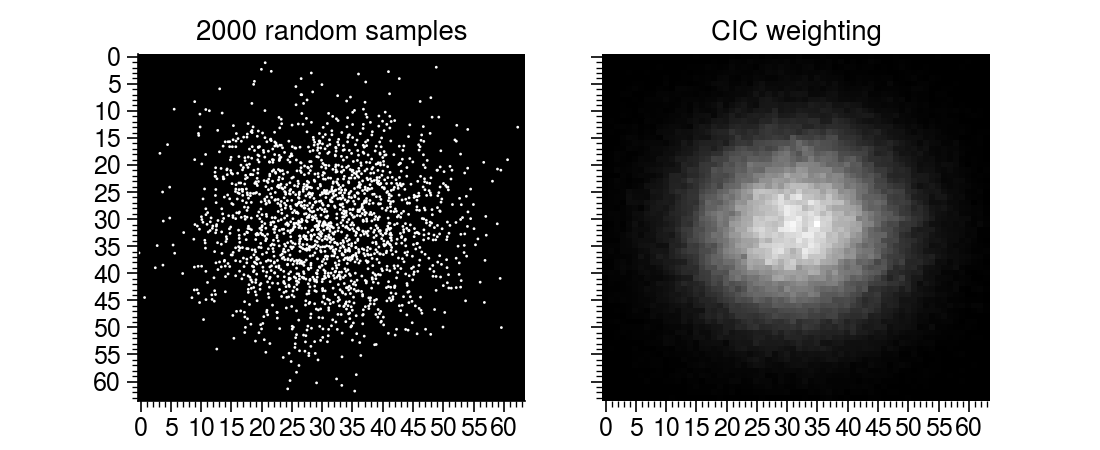

In [9]:
#hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2.25), sharey=True, sharex=True)
X_samp = rand_rows(bunch.X, 2000)
x = (X_samp[:, 0] - grid.xmin) / grid.dx
y = (X_samp[:, 2] - grid.ymin) / grid.dy
ax1.set_facecolor('k')
ax1.scatter(x, y, s=1, c='w', ec='none')
ax1.grid(False)
myplt.despine([ax1])
sns.heatmap(rho.T, ax=ax2, cmap='binary_r', cbar=False)
myplt.set_labels((ax1, ax2), ['2000 random samples', 'CIC weighting'], 'title');

### Field solver 

The workhorse in the simulation loop is the field solver. We need to solve Poisson's equation:

$$\left({\frac{\partial^2}{dx^2} + \frac{\partial^2}{dy^2}}\right) = -\frac{\rho\left(x, y\right)}{\varepsilon_0}. \tag{6}$$

The discretized version of the equation reads

$$ \frac{\phi_{i+1,j} + -2\phi_{i,j} +\phi_{i-1,j}}{{\Delta_x}^2} + \frac{\phi_{i,j+1} + -2\phi_{i,j} + \phi_{i,j-1}}{{\Delta_y}^2} = -\frac{\rho_{i,j}}{\varepsilon_0} \tag{7}$$

for a grid with spacing $\Delta_x$ and $\Delta_y$. There are multiple paths to a solution; we will focus on the method implemented in PyORBIT, which utilizes the Fourier convolution theorem. 

#### Green's functions and convolution theorem

The potential from an infinite line charge at the origin with charge density $\lambda$ is 

$$ \phi(\mathbf{x}) = -\frac{\lambda}{2\pi\varepsilon_0} \ln{|\mathbf{x}|} = -\frac{\lambda}{2\pi\varepsilon_0} \int{\ln{|\mathbf{x} - \mathbf{q}|}\delta(\mathbf{q})d\mathbf{q}}. \tag{8}$$

Note that $\mathbf{q}$ is just a dummy variable; usually a prime is used, but we already assigned physical meaning to $\mathbf{x}'$. By defining $G(\mathbf{x} - \mathbf{q}) = -\frac{\lambda}{2\pi\varepsilon_0} \ln{|\mathbf{x} - \mathbf{q}|}$ and $\rho(\mathbf{x}) = \delta(\mathbf{x})$, we have

$$ \phi(\mathbf{x}) = \int{G(\mathbf{x} - \mathbf{q})\rho(\mathbf{q})d\mathbf{q}} = G(\mathbf{x}) * \rho(\mathbf{x}). \tag{9}$$

In this form the potential is a [convolution](https://en.wikipedia.org/wiki/Convolution) (represented by $*$) of the transverse charge density $\rho$ with $G$, which is called the [Green's function](https://en.wikipedia.org/wiki/Green%27s_function). On the grid this will look like

$$ \phi_{i, j} = \sum_{k,l \ne i,j}{G_{i-k, j-l} \rho_{k, l}}. \tag{11}$$

This solves the problem in $O(N^2)$ time complexity for $N$ grid points. This is already much faster than a direct force calculation but could still get expensive for fine grids. We can speed things up by exploiting the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem), which says that the Fourier transform of a convolution of two functions is equal to the product of their Fourier transforms. The Fourier transform is defined by

$$\hat{\phi}(\mathbf{k})= \mathcal{F}\left[\phi(\mathbf{x})\right] = \int_{-\infty}^{\infty}{e^{-\mathbf{k}\cdot\mathbf{x}} \phi(\mathbf{x}) d\mathbf{x}}. \tag{12}$$

The convolution theorem then says
$$\mathcal{F}\left[\rho * G\right] = \mathcal{F}\left[\rho\right] \cdot \mathcal{F}\left[G\right]. \tag{13}$$

The dot represents the pointwise product. For the discrete equation this gives

$$\hat{\phi}_{n, m} = \hat{\rho}_{n, m} \hat{G}_{n, m}, \tag{14}$$

where the hat represents the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (DFT). With the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm at our disposal, the time complexity can be reduced to $O\left(N \log N\right)$. 

#### Implementation

There is a caveat to this method: to use the FFT algorithm, Eq. (11) must be a circular convolution, which means $G$ must be periodic. But the beam is in free space (we've neglected any conducting boundary), so this is not true. We can make it true by doubling the grid size in each dimension. We then make $G$ a mirror reflection in the new quadrants so that it is periodic, and also set the charge density equal to zero in these regions. After running the method on this larger grid, the potential in the new quadrants will be unphysical; however, the potential in the original quadrant will be correct. There are also some tricks we can play to reduce the space complexity, and in the end doubling the grid size is not much of a price to pay for the gain in speed. The method is implemented in the `PoissonSolver` class.

In [10]:
from scipy.fft import fft2, ifft2

class PoissonSolver:
    """Class to solve Poisson's equation on a 2D grid.

    Attributes
    ----------
    rho, phi, G : ndarray, shape (2*Nx, 2*Ny)
        Charge density (rho), potential (phi), and Green's function (G) at each
        grid point on a doubled grid. Only one quadrant (i < Nx, j < Ny)
        corresponds to to the real potential.
    sign : {-1.0, 1.0}
        If `sign` is positive, this will cause like-charges to attract instead
        of repel.
    """
    def __init__(self, grid, sign=-1.):
        self.grid = grid
        new_shape = (2 * self.grid.Nx, 2 * self.grid.Ny)
        self.rho, self.G = np.zeros(new_shape), np.zeros(new_shape)
        self.phi = np.zeros(new_shape)
        self.sign = sign
        
    def set_grid(self, grid):
        self.__init__(grid)
        
    def _compute_greens_function(self, line_charge_density):
        """Compute Green's function on doubled grid."""
        Nx, Ny = self.grid.Nx, self.grid.Ny
        Y, X = np.meshgrid(self.grid.x - self.grid.xmin,
                           self.grid.y - self.grid.ymin)
        self.G[:Nx, :Ny] = np.log(X**2 + Y**2, out=np.zeros_like(X),
                                  where=(X+Y>0))
        self.G *= self.sign * 0.5 * line_charge_density / (2 * pi * epsilon_0)
        self.G[Nx:, :] = np.flip(self.G[:Nx, :], axis=0)
        self.G[:, Ny:] = np.flip(self.G[:, :Ny], axis=1)
                
    def get_potential(self, rho, line_charge_density):
        """Compute the electric potential on the grid.
        
        Parameters
        ----------
        rho : ndarray, shape (Nx, Ny)
            Charge density at each grid point [C / m^2].
        line_charge_density : float
            Longitudinal charge density [C / m].
        
        Returns
        -------
        phi : ndarray, shape (Nx, Ny)
            Electric potential at each grid point.
        """
        Nx, Ny = self.grid.Nx, self.grid.Ny
        self.rho[:Nx, :Ny] = rho
        self._compute_greens_function(line_charge_density)
        self.phi = ifft2(fft2(self.G) * fft2(self.rho)).real
        return self.phi[:Nx, :Ny]

Running the algorithm gives the following potential on the doubled grid:

In [11]:
solver = PoissonSolver(grid)
phi = solver.get_potential(rho, bunch.line_charge_density)

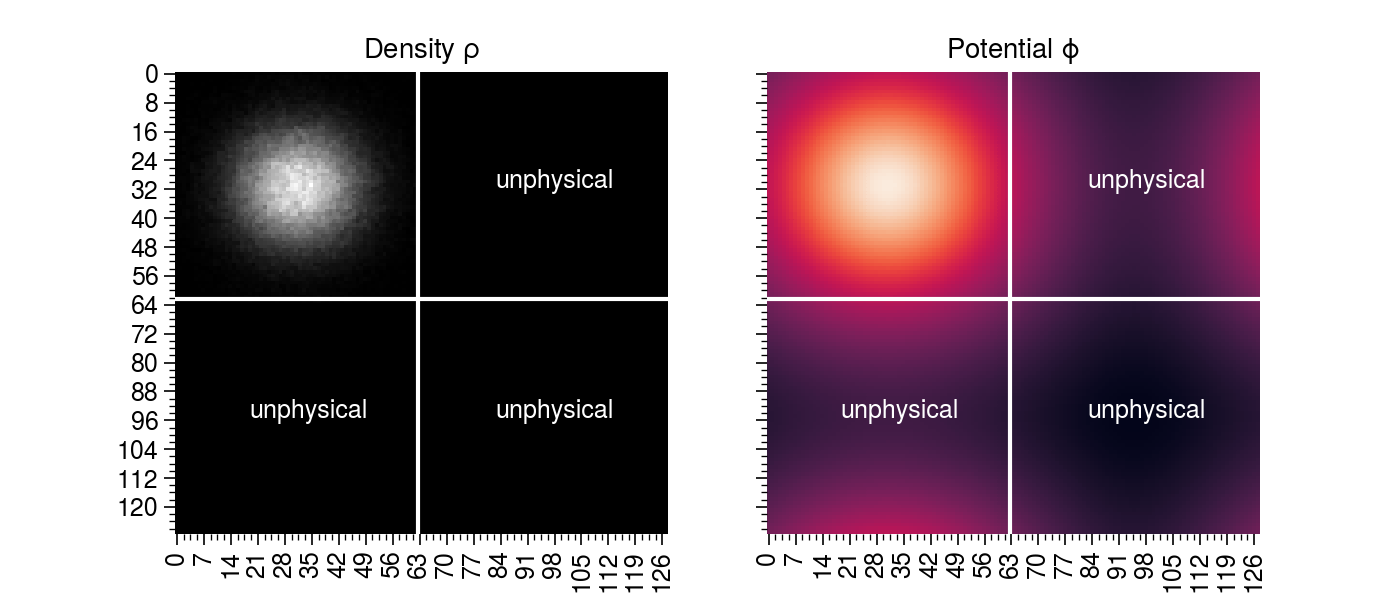

In [12]:
#hide_input
fig, axes = plt.subplots(ncols=2, figsize=(7, 3), sharey=True)
sns.heatmap(solver.rho.T, ax=axes[0], cmap='binary_r', cbar=False)
sns.heatmap(solver.phi.T, ax=axes[1], cbar=False)
for ax in axes:
    ax.axvline(grid.Nx - 1, c='w'); ax.axhline(grid.Ny - 1, c='w')
    for xy in [(0.65, 0.75), (0.15, 0.25), (0.65, 0.25)]:
        ax.annotate('unphysical', xy=xy, xycoords='axes fraction', c='w')
myplt.set_labels(axes, [r'Density $\rho$', r'Potential $\phi$'], 'title')

We can then compute the electric field at every grid point using second-order centered differencing. This gives

$$(E_x)_{i,j} = -\frac{\phi_{i+1,j} - \phi_{i-1,j}}{2\Delta_x}, $$

$$(E_y)_{i,j} = -\frac{\phi_{i,j+1} - \phi_{i,j-1}}{2\Delta_y}. $$

In [13]:
Ex, Ey = grid.gradient(-phi)

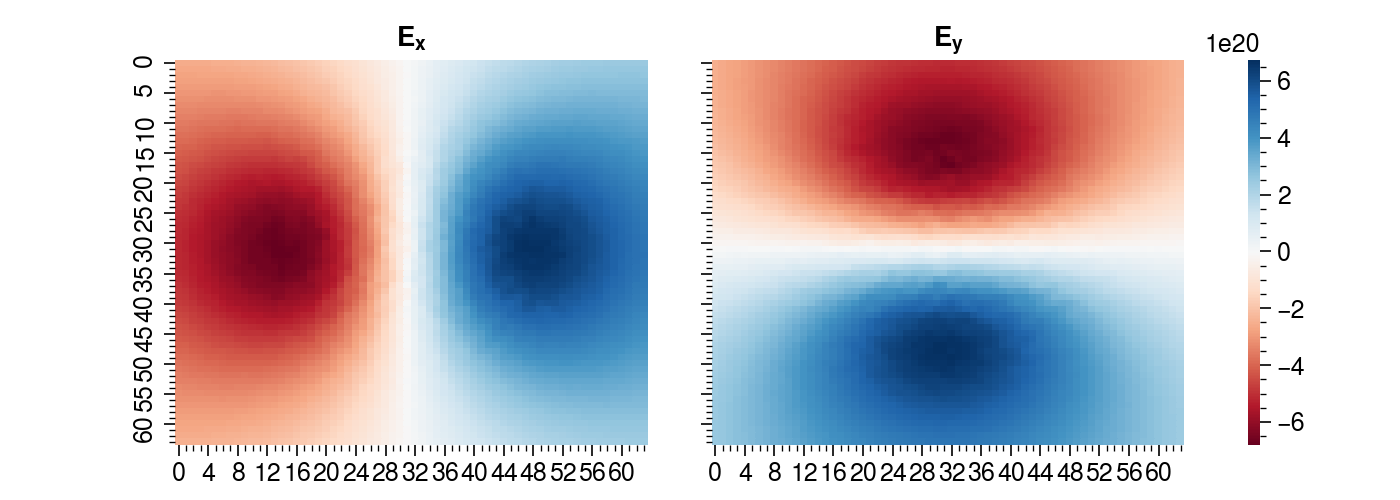

In [14]:
#hide_input
fig, axes = plt.subplots(ncols=3, figsize=(7, 2.5), 
                         gridspec_kw=dict(width_ratios=[1, 1, 0.025]))
ax1, ax2, ax3 = axes
myplt.set_share_axes(axes[:2], sharex=True, sharey=True)
sns.heatmap(Ex.T, ax=ax1, cmap='RdBu', cbar=False);
sns.heatmap(Ey.T, ax=ax2, cmap='RdBu', cbar_ax=ax3);
myplt.set_labels(axes[:2], ['$E_x$', '$E_y$'], 'title', fontweight='bold');

Finally, the value of the electric field at each particle position can be interpolated.

In [15]:
Ex_int = grid.interpolate(Ex, bunch.positions)
Ey_int = grid.interpolate(Ey, bunch.positions)

### Particle mover 

All we need to do in this step is integrate the equations of motion. One common method is [leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration) in which the position and velocity are integrated out of phase as follows:

$$ m\left(\frac{\mathbf{v}_{i+1/2} - \mathbf{v}_{i-1/2}}{\Delta_t}\right) = \mathbf{F}(\mathbf{x}_i),$$

$$ \frac{\mathbf{x}_{i+1} - \mathbf{x}_i}{\Delta_t} = \mathbf{v}_{i+1/2}$$

<img src='images_2021-02-15/leapfrog.png' width=500>
<figcaption>Credit: S. Lund</figcaption>

I should also mention that a different scheme must be used when magnetic fields are present. This is a symplectic integrator, which means it conserves energy. It is also second-order accurate, meaning that its error is proportional to the square of the $\Delta_t$. Finally, it is time-reversible. Because the velocity and position are out of phase, we need to push the velocity back one half-step before starting the simulation, and push it one half-step forward when taking a measurement. 

## Putting it all together

### Simulation loop

We have all the tools to implement the simulation loop. While $s < s_{max}$ we: 
1. Compute the charge density on the grid.
2. Find the electric potential on the grid.
3. Interpolate the electric field at the particle positions.
3. Update the particle positions.

We'll first create a `History` class which stores the beam moments or phase space coordinates.

In [16]:
class History:
    """Class to store bunch data over time.
    
    Atributes
    ---------
    moments : list
        Beam moment vectors; each element is ndarray of shape (10,).
    coords : list
        Bunch coordinate arrays.
    moment_positions, coord_positions : list
        Positions corresponding to each element of `moments` or `coords`.
    """
    def __init__(self, bunch, samples=None):
        self.X = bunch.X
        self.moments, self.coords = [], []
        self.moment_positions, self.coord_positions = [], []
        if samples is None or samples >= bunch.nparts:
            self.idx = np.arange(bunch.nparts)
        else:
            self.idx = np.random.choice(bunch.nparts, samples, replace=False)
        
    def store_moments(self, s):
        Sigma = np.cov(self.X.T)
        self.moments.append(Sigma[np.triu_indices(4)])
        self.moment_positions.append(s)
        
    def store_coords(self, s):
        self.coords.append(np.copy(self.X[self.idx, :]))
        self.coord_positions.append(s)
        
    def package(self, mm_mrad):
        self.moments = np.array(self.moments)
        self.coords = np.array(self.coords)
        if mm_mrad:
            self.moments *= 1e6
            self.coords *= 1e3

Now we'll create a `Simulation` class. There is a factor of 4 missing in my calculation, and I'm not sure where it is coming from. For now I'll just act like a didn't see it.

In [17]:
class Simulation:
    """Class to simulate the evolution of a charged particle bunch.
        
    Attributes
    ----------
    bunch : Bunch:
        The bunch to track.
    length : float
        Total tracking distance [m].
    step_size : float
        Distance between force calculations.
    nsteps : float
        Total number of steps = int(length / ds).
    steps_performed : int
        Number of steps performed so far.
    s : float
        The current bunch position.
    positions : ndarray, shape (nsteps + 1,)
        Positions at which coordinates are updated.
    history : History object
        Object storing the bunch data at each position.
    meas_every : dict or int
        Keys should be 'moments' and 'coords'. Values correspond to the 
        number of simulations steps between storing these quantities. For
        example, `meas_every = {'coords':4, 'moments':2}` will store the
        moments every 4 steps and the moments every other step. If an 
        int is provided, this will be applied to both. Defaults to the
        start and end of the simulation.
    samples : int
        Number of bunch particles to store when measuring the phase space
        coordinates. Defaults to the entire coordinate array.
    mm_mrad : bool
        If True, use units of mm-mrad. Otherwise use m-rad.
    ext_foc : callable
        Function returning the external kx and ky at the current position 
        such that u'' = -ku. Call signature is `kx, ky = ext_foc(s)`.
    """
    def __init__(self, bunch, length, step_size, grid_size, meas_every={}, 
                 samples=None, mm_mrad=True, ext_foc=None):
        self.bunch = bunch
        self.length, self.ds = length, step_size 
        self.nsteps = int(length / step_size)
        self.positions = np.linspace(0, length, self.nsteps + 1)
        self.grid = Grid(size=grid_size)
        self.solver = PoissonSolver(self.grid)
        self.fields = np.zeros((bunch.nparts, 2))
        self.history = History(bunch, samples)  
        self.ext_foc = ext_foc
        if type(meas_every) is int:
            meas_every = {'moments': meas_every, 'coords':meas_every}
        meas_every.setdefault('moments', self.nsteps)
        meas_every.setdefault('coords', self.nsteps)
        for key in meas_every.keys():
             if meas_every[key] is None:
                meas_every[key] = self.nsteps
        self.meas_every = (meas_every['moments'], meas_every['coords'])
        self.mm_mrad = mm_mrad
        self.s, self.steps_performed = 0.0, 0
        
    def set_grid(self):
        """Determine grid limits."""
        self.bunch.compute_extremum()
        self.grid.set_lims(self.bunch.xlim, self.bunch.ylim)
        self.solver.set_grid(self.grid)
        
    def compute_electric_field(self):
        """Compute the self-generated electric field."""
        self.set_grid()
        rho = self.grid.distribute(self.bunch.positions)
        rho *= self.bunch.line_charge_density * 4 # unknown origin
        phi = self.solver.get_potential(rho, self.bunch.line_charge_density)
        Ex, Ey = self.grid.gradient(-phi)
        self.fields[:, 0] = self.grid.interpolate(Ex, self.bunch.positions)
        self.fields[:, 1] = self.grid.interpolate(Ey, self.bunch.positions)
                            
    def kick(self, ds):
        """Update particle slopes."""
        # Space charge
        dxp_ds = self.bunch.sc_factor * self.fields[:, 0]
        dyp_ds = self.bunch.sc_factor * self.fields[:, 1]
        # External forces
        if self.ext_foc is not None:
            kx, ky = self.ext_foc(self.s)
            dxp_ds -= kx * self.bunch.X[:, 0]
            dyp_ds -= ky * self.bunch.X[:, 2]
        self.bunch.X[:, 1] += dxp_ds * ds
        self.bunch.X[:, 3] += dyp_ds * ds
        
    def push(self, ds):
        """Update particle positions."""
        self.bunch.X[:, 0] += self.bunch.X[:, 1] * ds
        self.bunch.X[:, 2] += self.bunch.X[:, 3] * ds
        
    def desync(self):
        """Advance velocity one half step backward."""
        self.kick(-0.5 * self.ds)
        
    def sync(self):
        """Advance velocity one half step forward."""
        self.kick(+0.5 * self.ds)
        
    def store(self):
        """Store bunch coordinates or statistics."""
        store_moments = self.steps_performed % self.meas_every[0] == 0
        store_coords = self.steps_performed % self.meas_every[1] == 0
        if not (store_moments or store_coords):
            return
        Xp = np.copy(self.bunch.X[:, [1, 3]])
        self.kick(+0.5 * self.ds) # sync positions/slope
        if store_moments:
            self.history.store_moments(self.s)
        if store_coords:
            self.history.store_coords(self.s)
        self.bunch.X[:, [1, 3]] = Xp
        
    def run(self):
        """Run the simulation."""
        self.compute_electric_field()
        self.store()
        self.kick(-0.5 * self.ds) # desync positions/slope
        for i in trange(self.nsteps):
            self.compute_electric_field()
            self.kick(self.ds)
            self.push(self.ds)
            self.s += self.ds
            self.steps_performed += 1
            self.store()
        self.history.package(self.mm_mrad)

### Demonstration

To demonstrate our method, we need some way of checking its accuracy. Real bunch measurements will be noisy and infrequent along the accelerator, so this could be pain. Luckily, there is an analytic benchmark available: the Kapchinskij-Vladimirskij (KV) distribution. Without going into any details, the beam projects to a uniform density ellipse in $x$-$y$ space, and the space charge forces produced within this ellipse are *linear*. If we plug the KV distribution into the Vlasov equation, it can be seen that these forces will remain linear for all time if the external focusing forces are also linear. As a consequence, a set of self-consistent differential equations describing the boundary of the ellipse can be written down. This is a remarkable fact. For now I won't show these equations; I'll just integrate them behind the scenes and compare with the calculations.

Now for the simulation. We'll look at to situations: 1) drift space and 2) FODO lattice. 1) is a region in which there are no external fields, so only the bunch's electric field is present. 2) is one of the basic building blocks of an accelerator, consisting of a series of alternating focusing and defocusing quadrupoles. This was covered in a [previous post](https://austin-hoover.github.io/blog/physics/accelerators/2021/01/21/parametric_oscillators.html). There is some thinking which much take place in our choice of spatial and temporal resulution. There are some guidelines given in this [paper](https://journals.aps.org/prab/abstract/10.1103/PhysRevSTAB.12.114801); for example, the grid spacing should be much less than the beam size to clearly resolve the beam edge, the number of macroparticles per cell should be large enough to collect good statistics, and the simulation step distance should be small enough to resolve the dynamics of the system. There is also the tradeoff between accuracy and runtime; for our purposes runtime is not really important since we are tracking such a small distance. Here are the simulation parameters we'll use.

In [18]:
nparts = int(2e5)
bunch_length = 250.0 # [m], circumference of SNS accumulator ring
intensity = 15e14 # about 10 times higher than SNS intensity
tracking_distance = 5.0 # [m]
step_size = 0.02 # [m]
grid_size = (128, 128)

Let's first track through a drift of length 5 meters. We'll compare the KV distribution to the envelope calculation and also to the Gaussian distribution.

In [19]:
def create_bunches(emittances): 
    bunches = {}
    for kind, eps in zip(('kv', 'gauss'), emittances):
        bunches[kind] = Bunch(intensity=intensity, length=bunch_length)
        bunches[kind].fill(dg.generate(kind, nparts, eps, cut=3))
    return bunches

In [21]:
bunches = create_bunches((100e-6, 25e-6))
tracking_distance = 5.0
meas_every = {'moments': int(0.1 * tracking_distance/step_size),
              'coords' : int(0.015 * tracking_distance/step_size)}
sims = {}
for kind, bunch in bunches.items():
    sims[kind] = Simulation(bunch, tracking_distance, step_size, grid_size, 
                            meas_every=meas_every, samples=10000)
    sims[kind].run()
    
moments = {kind: sim.history.moments for kind, sim in sims.items()}
coords = {kind: sim.history.coords for kind, sim in sims.items()}

100%|██████████| 250/250 [00:51<00:00,  4.83it/s]


In [23]:
#hide
Sigma0 = 1e-6 * vec_to_mat(sims['kv'].history.moments[0])
env_solver = EnvelopeSolver(Sigma0, sims['kv'].positions, bunches['kv'].perveance)
env_solver.integrate()
moments_theory = env_solver.moments
env_solver.reset()
env_solver.set_perveance(0.)
env_solver.integrate()
moments_theory_0 = env_solver.moments

In [24]:
#hide
columns = ['x2','xxp','xy','xyp','xp2','yxp','xpyp','y2','yyp','yp2']
def make_df(moments, positions):
    df = pd.DataFrame(moments, columns=columns)
    df[['x_rms','y_rms']] = np.sqrt(df[['x2','y2']])
    df['s'] = positions
    return df.copy()

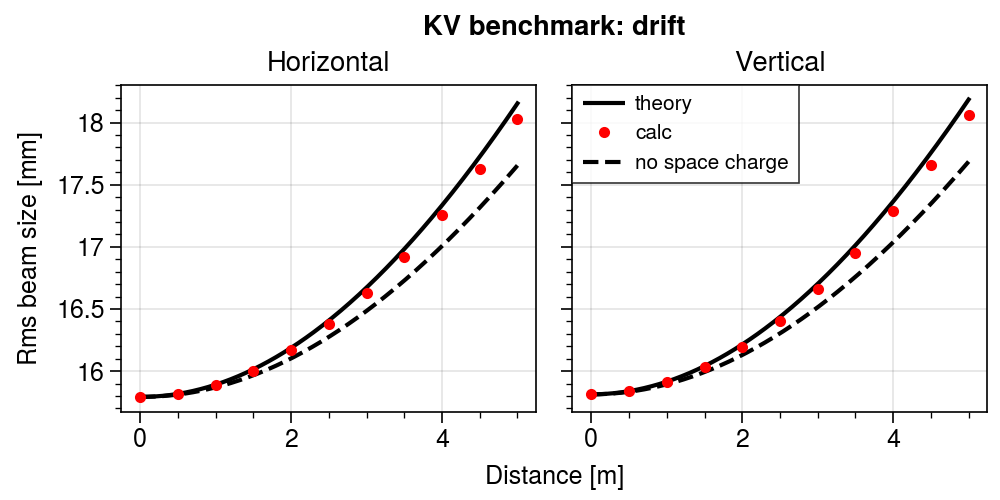

In [25]:
# hide_input
moments = {}
for kind, sim in sims.items():
    moments[kind] = make_df(sim.history.moments, sim.history.moment_positions)
moments['env'] = make_df(moments_theory, env_solver.positions)
moments['env0'] = make_df(moments_theory_0, env_solver.positions)

fig, axes = plot.subplots(ncols=2, figsize=(5, 2.5), spany=False)
for ax, key in zip(axes, ['x_rms', 'y_rms']):
    moments['env'][['s', key]].plot('s', ax=ax, legend=False, c='k')
    moments['kv'][['s', key]].plot('s', ax=ax, legend=False, c='r', marker='.', lw=0, zorder=10)
    moments['env0'][['s', key]].plot('s', ax=ax, legend=False, c='k', ls='--')
for ax, title in zip(axes, ['Horizontal', 'Vertical']):
    ax.set_title(title)
axes.format(ylabel='Rms beam size [$mm$]', xlabel='Distance [m]', suptitle='KV benchmark: drift')
axes[1].legend(labels=['theory', 'calc', 'no space charge'], ncols=1, fontsize='small');

The agreement is pretty good, and we expect some small fluctuations when we calculate the moments. Without storing the bunch coordinates, the same PyORBIT simulation about 10 times faster. I was quite happy with the performance given that PyORBIT directly calls C++ routines.

In [26]:
#hide
def side_by_side(coords1, coords2, positions, texts=None, fps=12):
    """Side-by-side animation of distributions in x-y space."""
    fig, axes = plt.subplots(1, 2, sharey='row', sharex='row', figsize=(7.5, 3.5))
    ax1, ax2 = axes
    myplt.despine(axes)
    myplt.set_labels(axes, 2*['x [mm]'], 'xlabel')
    ax1.set_ylabel('y [mm]')
    umax1, _ = myplt.get_u_up_max_global(coords1)
    umax2, _ = myplt.get_u_up_max_global(coords2)
    umax = 1.0 * max(umax1, umax2)
    for ax in axes:
        ax.set_xlim(-umax, umax)
        ax.set_ylim(-umax, umax)
        ax.grid(False)
    plt.close()

    plt_kws = {'ms':2, 'color':'k', 'marker':'.', 'lw':0, 
               'markeredgewidth':0, 'fillstyle':'full'}
    line1, = ax1.plot([], [], **plt_kws)
    line2, = ax2.plot([], [], **plt_kws)

    def update(t):
        line1.set_data(coords1[t, :, 0], coords1[t, :, 2])
        line2.set_data(coords2[t, :, 0], coords2[t, :, 2])
        ax1.set_title('s = {:.2f} m'.format(positions[t]))
        if texts is not None:
            for ax in axes:
                for text in ax.texts:
                    text.set_visible(False)
                ax.annotate(texts[t], xy=(0.75, 0.85), xycoords='axes fraction')
                ax.annotate(texts[t], xy=(0.75, 0.75), xycoords='axes fraction')

    return animation.FuncAnimation(fig, update, frames=coords1.shape[0], interval=1000/fps)

In [27]:
#hide_input
texts = None
side_by_side(coords['kv'], coords['gauss'], sims['kv'].history.coord_positions, texts)

Comments.

Now we'll track through a FODO lattice. The external fields simply add a term proportional to $x$ or $y$ in Eq. (1), so that

$$ x'' + k_x(s)x = \frac{q}{mv_s^2\gamma^3} E_x,$$

and similar for $y$. These fields cause the beam to periodically breath in and out, expanding in one dimension while contracting in the other.

In [ ]:
#hide
# Create FODO lattice
lattice_length = 5.0 # [m]
fill_fac = 1/3
fodo = FODO(k0, lattice_length, fill_fac=fill_fac)

# Find the matched beta functions in the lattice
lattice = ml.fodo(k0, k0, lattice_length, fill_fac=fill_fac)
fodo_matched_twiss = (0.0, 0.0, lattice.params2D['bx'], lattice.params2D['by'])
dg.set_twiss(*fodo_matched_twiss)

# Run simulation
bunches = create_bunches((100e-6, 25e-6))
tracking_distance = 10.0
sims = {}
for kind, bunch in bunches.items():
    sims[kind] = Simulation(bunch, tracking_distance, step_size, grid_size, 
                            meas_every=meas_every, samples=10000, 
                            ext_foc = fodo.foc_strength)
    sims[kind].run()
    
moments = {kind: sim.history.moments for kind, sim in sims.items()}
coords = {kind: sim.history.coords for kind, sim in sims.items()}

 24%|██▎       | 118/500 [00:24<01:16,  4.97it/s]

In [ ]:
# hide_input
Sigma0 = 1e-6 * vec_to_mat(sims['kv'].history.moments[0])
env_solver = EnvelopeSolver(Sigma0, sims['kv'].positions, bunches['kv'].perveance)
env_solver.integrate()
moments_theory = env_solver.moments
env_solver.reset()
env_solver.set_perveance(0.)
env_solver.integrate()
moments_theory_0 = env_solver.moments

moments = {}
for kind, sim in sims.items():
    moments[kind] = make_df(sim.history.moments, sim.history.moment_positions)
moments['env'] = make_df(moments_theory, env_solver.positions)
moments['env0'] = make_df(moments_theory_0, env_solver.positions)

fig, axes = plot.subplots(ncols=2, figsize=(5, 2.5), spany=False)
for ax, key in zip(axes, ['x_rms', 'y_rms']):
    moments['env'][['s', key]].plot('s', ax=ax, legend=False, c='k')
    moments['kv'][['s', key]].plot('s', ax=ax, legend=False, c='r', marker='.', lw=0, zorder=10)
    moments['env0'][['s', key]].plot('s', ax=ax, legend=False, c='k', ls='--')
for ax, title in zip(axes, ['Horizontal', 'Vertical']):
    ax.set_title(title)
axes.format(ylabel='Rms beam size [$mm$]', xlabel='Distance [m]', suptitle='KV benchmark')
axes[1].legend(labels=['theory', 'calc', 'no space charge'], ncols=1, fontsize='small');

In [ ]:
# hide_input
moments = {}
for kind, sim in sims.items():
    moments[kind] = make_df(sim.history.moments, sim.history.moment_positions)
moments['env'] = make_df(moments_theory, env_solver.positions)
moments['env0'] = make_df(moments_theory_0, env_solver.positions)

fig, axes = plot.subplots(ncols=2, figsize=(5, 2.5), spany=False)
for ax, key in zip(axes, ['x_rms', 'y_rms']):
    moments['env'][['s', key]].plot('s', ax=ax, legend=False, c='k')
    moments['kv'][['s', key]].plot('s', ax=ax, legend=False, c='r', marker='.', lw=0, zorder=10)
    moments['env0'][['s', key]].plot('s', ax=ax, legend=False, c='k', ls='--')
for ax, title in zip(axes, ['Horizontal', 'Vertical']):
    ax.set_title(title)
axes.format(ylabel='Rms beam size [$mm$]', xlabel='Distance [m]', suptitle='KV benchmark: FODO')
axes[1].legend(labels=['theory', 'calc', 'no space charge'], ncols=1, fontsize='small');

I thought it would be interesting to change the laws of physics so that like-charges attract instead of repel. Then we can run a sort of 2D galaxy collision, since [Gauss' law for gravity](https://en.wikipedia.org/wiki/Gauss%27s_law_for_gravity) has the same form as in electrostatics.

## Conclusion 

In this post, we implemented an electrostatic PIC simulation in Python. Modern plasma simulation codes are very complex, and one could fill all their time learning about the different techniques these codes implement. If I were to continue developing this code, the next step would be to consider magnetic fields. It would also be straightforward to extend the code to 3D.